<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:14:52] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


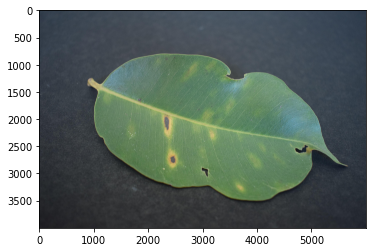

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

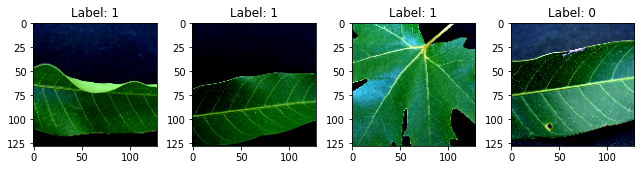

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:14:58] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:15:00] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2548054758685847 samples/sec                   batch loss = 1.098718285560608 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2687831484898067 samples/sec                   batch loss = 0.6517990231513977 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.259937907346454 samples/sec                   batch loss = 0.2836199402809143 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.2548710802425758 samples/sec                   batch loss = 0.7138698697090149 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.2560407204401693 samples/sec                   batch loss = 1.535853624343872 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2484925931565 samples/sec                   batch loss = 0.850663423538208 | accuracy = 0.6


Epoch[1] Batch[35] Speed: 1.2085324447200951 samples/sec                   batch loss = 0.45859771966934204 | accuracy = 0.6


Epoch[1] Batch[40] Speed: 1.2553233645016453 samples/sec                   batch loss = 0.4038660228252411 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2561549828361889 samples/sec                   batch loss = 0.6072895526885986 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.2545871256056835 samples/sec                   batch loss = 0.6642796397209167 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2549995870829986 samples/sec                   batch loss = 0.42642730474472046 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.2542889520972007 samples/sec                   batch loss = 0.9156882166862488 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2520802870381544 samples/sec                   batch loss = 0.3697647750377655 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.2602201244279525 samples/sec                   batch loss = 0.6901132464408875 | accuracy = 0.625


Epoch[1] Batch[75] Speed: 1.2532038190963783 samples/sec                   batch loss = 0.6168355941772461 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.2512384692442577 samples/sec                   batch loss = 0.2445974051952362 | accuracy = 0.63125


Epoch[1] Batch[85] Speed: 1.2569109546579162 samples/sec                   batch loss = 0.36985310912132263 | accuracy = 0.638235294117647


Epoch[1] Batch[90] Speed: 1.2526927282933478 samples/sec                   batch loss = 0.7240164279937744 | accuracy = 0.6444444444444445


Epoch[1] Batch[95] Speed: 1.2621045226045975 samples/sec                   batch loss = 0.9214831590652466 | accuracy = 0.65


Epoch[1] Batch[100] Speed: 1.2567426103369774 samples/sec                   batch loss = 0.6169736385345459 | accuracy = 0.65


Epoch[1] Batch[105] Speed: 1.2574983472920325 samples/sec                   batch loss = 0.7869649529457092 | accuracy = 0.6476190476190476


Epoch[1] Batch[110] Speed: 1.2529502801644998 samples/sec                   batch loss = 1.1553516387939453 | accuracy = 0.6477272727272727


Epoch[1] Batch[115] Speed: 1.2552140427741392 samples/sec                   batch loss = 0.602105438709259 | accuracy = 0.6521739130434783


Epoch[1] Batch[120] Speed: 1.257323061242843 samples/sec                   batch loss = 0.6473969221115112 | accuracy = 0.6583333333333333


Epoch[1] Batch[125] Speed: 1.2539868900000748 samples/sec                   batch loss = 0.4431268870830536 | accuracy = 0.66


Epoch[1] Batch[130] Speed: 1.2554340204844805 samples/sec                   batch loss = 0.520504355430603 | accuracy = 0.6596153846153846


Epoch[1] Batch[135] Speed: 1.2619614571529472 samples/sec                   batch loss = 0.5759220123291016 | accuracy = 0.6611111111111111


Epoch[1] Batch[140] Speed: 1.2525132623821364 samples/sec                   batch loss = 0.6286705732345581 | accuracy = 0.6607142857142857


Epoch[1] Batch[145] Speed: 1.2551555390534481 samples/sec                   batch loss = 1.0186138153076172 | accuracy = 0.6637931034482759


Epoch[1] Batch[150] Speed: 1.2587155759564337 samples/sec                   batch loss = 0.3674878776073456 | accuracy = 0.6616666666666666


Epoch[1] Batch[155] Speed: 1.2560544496374468 samples/sec                   batch loss = 0.41269832849502563 | accuracy = 0.6596774193548387


Epoch[1] Batch[160] Speed: 1.2530002498201034 samples/sec                   batch loss = 0.44016537070274353 | accuracy = 0.6609375


Epoch[1] Batch[165] Speed: 1.2542847323508068 samples/sec                   batch loss = 0.6816831231117249 | accuracy = 0.6575757575757576


Epoch[1] Batch[170] Speed: 1.2506461874530277 samples/sec                   batch loss = 0.11466038227081299 | accuracy = 0.6617647058823529


Epoch[1] Batch[175] Speed: 1.252174577623226 samples/sec                   batch loss = 0.6321468353271484 | accuracy = 0.6628571428571428


Epoch[1] Batch[180] Speed: 1.2559106840938343 samples/sec                   batch loss = 0.8208644390106201 | accuracy = 0.6652777777777777


Epoch[1] Batch[185] Speed: 1.254960534740798 samples/sec                   batch loss = 0.43164288997650146 | accuracy = 0.6635135135135135


Epoch[1] Batch[190] Speed: 1.2602063040150542 samples/sec                   batch loss = 0.7536316514015198 | accuracy = 0.6631578947368421


Epoch[1] Batch[195] Speed: 1.258953315022203 samples/sec                   batch loss = 0.46188610792160034 | accuracy = 0.6666666666666666


Epoch[1] Batch[200] Speed: 1.259474066556458 samples/sec                   batch loss = 0.6510694622993469 | accuracy = 0.67125


Epoch[1] Batch[205] Speed: 1.2607346297859883 samples/sec                   batch loss = 0.7357087731361389 | accuracy = 0.6719512195121952


Epoch[1] Batch[210] Speed: 1.256935061338945 samples/sec                   batch loss = 0.8252533674240112 | accuracy = 0.6714285714285714


Epoch[1] Batch[215] Speed: 1.2578536870413048 samples/sec                   batch loss = 0.5757668018341064 | accuracy = 0.6732558139534883


Epoch[1] Batch[220] Speed: 1.2619744617628241 samples/sec                   batch loss = 0.5251505374908447 | accuracy = 0.675


Epoch[1] Batch[225] Speed: 1.2566663618108376 samples/sec                   batch loss = 1.3576691150665283 | accuracy = 0.6755555555555556


Epoch[1] Batch[230] Speed: 1.250436737935252 samples/sec                   batch loss = 0.5577172636985779 | accuracy = 0.675


Epoch[1] Batch[235] Speed: 1.252259348476741 samples/sec                   batch loss = 0.30301886796951294 | accuracy = 0.675531914893617


Epoch[1] Batch[240] Speed: 1.2597025392323924 samples/sec                   batch loss = 0.6351092457771301 | accuracy = 0.6739583333333333


Epoch[1] Batch[245] Speed: 1.2605155372298842 samples/sec                   batch loss = 0.4496973752975464 | accuracy = 0.676530612244898


Epoch[1] Batch[250] Speed: 1.2611200499119588 samples/sec                   batch loss = 0.20405007898807526 | accuracy = 0.68


Epoch[1] Batch[255] Speed: 1.2575590491216013 samples/sec                   batch loss = 0.35036394000053406 | accuracy = 0.6813725490196079


Epoch[1] Batch[260] Speed: 1.2594575206369858 samples/sec                   batch loss = 0.7315598726272583 | accuracy = 0.6807692307692308


Epoch[1] Batch[265] Speed: 1.2505622873672697 samples/sec                   batch loss = 0.6765931248664856 | accuracy = 0.6792452830188679


Epoch[1] Batch[270] Speed: 1.2527895434004184 samples/sec                   batch loss = 0.7445791959762573 | accuracy = 0.6768518518518518


Epoch[1] Batch[275] Speed: 1.2532609239664299 samples/sec                   batch loss = 0.31441181898117065 | accuracy = 0.6781818181818182


Epoch[1] Batch[280] Speed: 1.2543399663888768 samples/sec                   batch loss = 0.36065465211868286 | accuracy = 0.6776785714285715


Epoch[1] Batch[285] Speed: 1.2562180946837957 samples/sec                   batch loss = 0.6014996767044067 | accuracy = 0.6763157894736842


Epoch[1] Batch[290] Speed: 1.2593920030650791 samples/sec                   batch loss = 0.5238178372383118 | accuracy = 0.6775862068965517


Epoch[1] Batch[295] Speed: 1.2592379265541316 samples/sec                   batch loss = 0.6090235710144043 | accuracy = 0.6796610169491526


Epoch[1] Batch[300] Speed: 1.2560338559540793 samples/sec                   batch loss = 0.5104935765266418 | accuracy = 0.6808333333333333


Epoch[1] Batch[305] Speed: 1.256557088390167 samples/sec                   batch loss = 0.8779674768447876 | accuracy = 0.6836065573770492


Epoch[1] Batch[310] Speed: 1.257439630446271 samples/sec                   batch loss = 0.3834090232849121 | accuracy = 0.6862903225806452


Epoch[1] Batch[315] Speed: 1.25490881290386 samples/sec                   batch loss = 0.5088754892349243 | accuracy = 0.6857142857142857


Epoch[1] Batch[320] Speed: 1.2564311792821907 samples/sec                   batch loss = 0.4570566415786743 | accuracy = 0.68359375


Epoch[1] Batch[325] Speed: 1.2550597662433591 samples/sec                   batch loss = 0.4514558017253876 | accuracy = 0.683076923076923


Epoch[1] Batch[330] Speed: 1.260733682399597 samples/sec                   batch loss = 0.4047894775867462 | accuracy = 0.6818181818181818


Epoch[1] Batch[335] Speed: 1.2553781264420445 samples/sec                   batch loss = 0.41674280166625977 | accuracy = 0.6813432835820895


Epoch[1] Batch[340] Speed: 1.2549607224866288 samples/sec                   batch loss = 0.5041611194610596 | accuracy = 0.6823529411764706


Epoch[1] Batch[345] Speed: 1.2522872029271062 samples/sec                   batch loss = 0.3367327153682709 | accuracy = 0.6847826086956522


Epoch[1] Batch[350] Speed: 1.2596717057140847 samples/sec                   batch loss = 0.3080650866031647 | accuracy = 0.6857142857142857


Epoch[1] Batch[355] Speed: 1.2514337186519031 samples/sec                   batch loss = 0.730076253414154 | accuracy = 0.6823943661971831


Epoch[1] Batch[360] Speed: 1.2490916710698623 samples/sec                   batch loss = 0.5349886417388916 | accuracy = 0.6798611111111111


Epoch[1] Batch[365] Speed: 1.2512851294317984 samples/sec                   batch loss = 1.331796407699585 | accuracy = 0.6808219178082192


Epoch[1] Batch[370] Speed: 1.2523496462644863 samples/sec                   batch loss = 1.6484661102294922 | accuracy = 0.6810810810810811


Epoch[1] Batch[375] Speed: 1.252156166948324 samples/sec                   batch loss = 0.7645498514175415 | accuracy = 0.6833333333333333


Epoch[1] Batch[380] Speed: 1.2664683109582409 samples/sec                   batch loss = 0.5042611956596375 | accuracy = 0.6835526315789474


Epoch[1] Batch[385] Speed: 1.2550002442345498 samples/sec                   batch loss = 0.36674341559410095 | accuracy = 0.687012987012987


Epoch[1] Batch[390] Speed: 1.2500551181002626 samples/sec                   batch loss = 0.4744513928890228 | accuracy = 0.6865384615384615


Epoch[1] Batch[395] Speed: 1.2528871219767777 samples/sec                   batch loss = 0.5663203597068787 | accuracy = 0.6873417721518987


Epoch[1] Batch[400] Speed: 1.2491565863179765 samples/sec                   batch loss = 0.31071537733078003 | accuracy = 0.688125


Epoch[1] Batch[405] Speed: 1.2507519175911441 samples/sec                   batch loss = 0.6258256435394287 | accuracy = 0.6876543209876543


Epoch[1] Batch[410] Speed: 1.254978934099232 samples/sec                   batch loss = 2.312349319458008 | accuracy = 0.6878048780487804


Epoch[1] Batch[415] Speed: 1.256230793064755 samples/sec                   batch loss = 0.7158566117286682 | accuracy = 0.686144578313253


Epoch[1] Batch[420] Speed: 1.2574782717342805 samples/sec                   batch loss = 1.1137123107910156 | accuracy = 0.6845238095238095


Epoch[1] Batch[425] Speed: 1.2527656890137515 samples/sec                   batch loss = 0.5232992172241211 | accuracy = 0.6858823529411765


Epoch[1] Batch[430] Speed: 1.2599320409952892 samples/sec                   batch loss = 0.48419997096061707 | accuracy = 0.6848837209302325


Epoch[1] Batch[435] Speed: 1.2556358440986923 samples/sec                   batch loss = 0.20243707299232483 | accuracy = 0.6856321839080459


Epoch[1] Batch[440] Speed: 1.2556275744449512 samples/sec                   batch loss = 0.8838669061660767 | accuracy = 0.6846590909090909


Epoch[1] Batch[445] Speed: 1.2554728204521874 samples/sec                   batch loss = 0.756114661693573 | accuracy = 0.6859550561797753


Epoch[1] Batch[450] Speed: 1.260986495584988 samples/sec                   batch loss = 1.0069358348846436 | accuracy = 0.685


Epoch[1] Batch[455] Speed: 1.2581857325809664 samples/sec                   batch loss = 1.2891687154769897 | accuracy = 0.6835164835164835


Epoch[1] Batch[460] Speed: 1.2567556017491128 samples/sec                   batch loss = 0.8984318971633911 | accuracy = 0.683695652173913


Epoch[1] Batch[465] Speed: 1.2533541752360364 samples/sec                   batch loss = 0.9261622428894043 | accuracy = 0.6817204301075269


Epoch[1] Batch[470] Speed: 1.251300248078995 samples/sec                   batch loss = 1.4688897132873535 | accuracy = 0.6835106382978723


Epoch[1] Batch[475] Speed: 1.2608316496909624 samples/sec                   batch loss = 0.44774138927459717 | accuracy = 0.6842105263157895


Epoch[1] Batch[480] Speed: 1.2552634418151698 samples/sec                   batch loss = 0.19351768493652344 | accuracy = 0.684375


Epoch[1] Batch[485] Speed: 1.2523124412507916 samples/sec                   batch loss = 0.3967568278312683 | accuracy = 0.6835051546391753


Epoch[1] Batch[490] Speed: 1.2574641344022004 samples/sec                   batch loss = 0.8912096619606018 | accuracy = 0.6826530612244898


Epoch[1] Batch[495] Speed: 1.2551604219804435 samples/sec                   batch loss = 0.6735008358955383 | accuracy = 0.6823232323232323


Epoch[1] Batch[500] Speed: 1.2563531809918316 samples/sec                   batch loss = 1.0829644203186035 | accuracy = 0.6815


Epoch[1] Batch[505] Speed: 1.2566518662242139 samples/sec                   batch loss = 0.4823654294013977 | accuracy = 0.6831683168316832


Epoch[1] Batch[510] Speed: 1.2572164056947714 samples/sec                   batch loss = 0.3401753306388855 | accuracy = 0.6848039215686275


Epoch[1] Batch[515] Speed: 1.247235888172621 samples/sec                   batch loss = 0.3444347381591797 | accuracy = 0.6849514563106797


Epoch[1] Batch[520] Speed: 1.2516820683427368 samples/sec                   batch loss = 0.7274391055107117 | accuracy = 0.6846153846153846


Epoch[1] Batch[525] Speed: 1.2577402468848522 samples/sec                   batch loss = 0.6123310923576355 | accuracy = 0.6847619047619048


Epoch[1] Batch[530] Speed: 1.2545603883172223 samples/sec                   batch loss = 0.43305662274360657 | accuracy = 0.6858490566037736


Epoch[1] Batch[535] Speed: 1.2542861389297832 samples/sec                   batch loss = 0.6715558767318726 | accuracy = 0.6864485981308411


Epoch[1] Batch[540] Speed: 1.2552033370307376 samples/sec                   batch loss = 0.6704620718955994 | accuracy = 0.687037037037037


Epoch[1] Batch[545] Speed: 1.2501023421029376 samples/sec                   batch loss = 1.1216362714767456 | accuracy = 0.6862385321100918


Epoch[1] Batch[550] Speed: 1.2475756170779653 samples/sec                   batch loss = 0.7851203680038452 | accuracy = 0.6872727272727273


Epoch[1] Batch[555] Speed: 1.241949749392469 samples/sec                   batch loss = 0.8675466179847717 | accuracy = 0.6869369369369369


Epoch[1] Batch[560] Speed: 1.2442810310883066 samples/sec                   batch loss = 0.4397944211959839 | accuracy = 0.6870535714285714


Epoch[1] Batch[565] Speed: 1.2511578486417538 samples/sec                   batch loss = 0.6903700232505798 | accuracy = 0.6853982300884955


Epoch[1] Batch[570] Speed: 1.2491148277409665 samples/sec                   batch loss = 0.3304269015789032 | accuracy = 0.6859649122807018


Epoch[1] Batch[575] Speed: 1.2579673363092672 samples/sec                   batch loss = 0.6905102729797363 | accuracy = 0.6865217391304348


Epoch[1] Batch[580] Speed: 1.2522647697156013 samples/sec                   batch loss = 0.28651660680770874 | accuracy = 0.6866379310344828


Epoch[1] Batch[585] Speed: 1.2564283564972394 samples/sec                   batch loss = 0.22087407112121582 | accuracy = 0.6876068376068376


Epoch[1] Batch[590] Speed: 1.25593757298822 samples/sec                   batch loss = 0.3382095694541931 | accuracy = 0.6894067796610169


Epoch[1] Batch[595] Speed: 1.256610357985159 samples/sec                   batch loss = 0.6101038455963135 | accuracy = 0.6890756302521008


Epoch[1] Batch[600] Speed: 1.252304308790963 samples/sec                   batch loss = 0.39750686287879944 | accuracy = 0.6895833333333333


Epoch[1] Batch[605] Speed: 1.249650274488253 samples/sec                   batch loss = 0.4098461866378784 | accuracy = 0.6913223140495868


Epoch[1] Batch[610] Speed: 1.253933842593679 samples/sec                   batch loss = 0.6519657373428345 | accuracy = 0.6913934426229508


Epoch[1] Batch[615] Speed: 1.2521450460415053 samples/sec                   batch loss = 0.719645082950592 | accuracy = 0.6926829268292682


Epoch[1] Batch[620] Speed: 1.2538688047257323 samples/sec                   batch loss = 0.7289167046546936 | accuracy = 0.6923387096774194


Epoch[1] Batch[625] Speed: 1.2566844346989048 samples/sec                   batch loss = 0.4759320318698883 | accuracy = 0.692


Epoch[1] Batch[630] Speed: 1.2497432684794179 samples/sec                   batch loss = 0.6949018239974976 | accuracy = 0.6912698412698413


Epoch[1] Batch[635] Speed: 1.2547050647192726 samples/sec                   batch loss = 1.3275704383850098 | accuracy = 0.6897637795275591


Epoch[1] Batch[640] Speed: 1.252196820683574 samples/sec                   batch loss = 0.7868942618370056 | accuracy = 0.688671875


Epoch[1] Batch[645] Speed: 1.2511822016869003 samples/sec                   batch loss = 0.22956468164920807 | accuracy = 0.6891472868217055


Epoch[1] Batch[650] Speed: 1.2451020518575322 samples/sec                   batch loss = 0.4790303707122803 | accuracy = 0.69


Epoch[1] Batch[655] Speed: 1.2530490068274869 samples/sec                   batch loss = 0.37241876125335693 | accuracy = 0.6904580152671755


Epoch[1] Batch[660] Speed: 1.2602032749239602 samples/sec                   batch loss = 0.8354266881942749 | accuracy = 0.6893939393939394


Epoch[1] Batch[665] Speed: 1.2569392989370283 samples/sec                   batch loss = 0.37390124797821045 | accuracy = 0.6887218045112782


Epoch[1] Batch[670] Speed: 1.2568022977379274 samples/sec                   batch loss = 0.3654831051826477 | accuracy = 0.6899253731343283


Epoch[1] Batch[675] Speed: 1.2547244888000249 samples/sec                   batch loss = 0.23269052803516388 | accuracy = 0.6907407407407408


Epoch[1] Batch[680] Speed: 1.2510125898251938 samples/sec                   batch loss = 0.8398270606994629 | accuracy = 0.6886029411764706


Epoch[1] Batch[685] Speed: 1.2496962577751194 samples/sec                   batch loss = 0.3598645329475403 | accuracy = 0.6901459854014599


Epoch[1] Batch[690] Speed: 1.2536396328243868 samples/sec                   batch loss = 0.2648218274116516 | accuracy = 0.6898550724637681


Epoch[1] Batch[695] Speed: 1.2519146354003203 samples/sec                   batch loss = 0.3509429097175598 | accuracy = 0.6917266187050359


Epoch[1] Batch[700] Speed: 1.2521702786354603 samples/sec                   batch loss = 0.7398622035980225 | accuracy = 0.6921428571428572


Epoch[1] Batch[705] Speed: 1.2508135551343569 samples/sec                   batch loss = 0.6299771666526794 | accuracy = 0.6911347517730496


Epoch[1] Batch[710] Speed: 1.2532117760203176 samples/sec                   batch loss = 1.2491050958633423 | accuracy = 0.6919014084507042


Epoch[1] Batch[715] Speed: 1.2550254981512605 samples/sec                   batch loss = 0.44919854402542114 | accuracy = 0.693006993006993


Epoch[1] Batch[720] Speed: 1.2438915383842029 samples/sec                   batch loss = 0.4566578269004822 | accuracy = 0.6930555555555555


Epoch[1] Batch[725] Speed: 1.2496193726420972 samples/sec                   batch loss = 0.513026773929596 | accuracy = 0.6937931034482758


Epoch[1] Batch[730] Speed: 1.2500002607703753 samples/sec                   batch loss = 0.382763147354126 | accuracy = 0.6945205479452055


Epoch[1] Batch[735] Speed: 1.2518401858582306 samples/sec                   batch loss = 0.21236756443977356 | accuracy = 0.6955782312925171


Epoch[1] Batch[740] Speed: 1.2455265149262669 samples/sec                   batch loss = 0.4700925946235657 | accuracy = 0.6962837837837837


Epoch[1] Batch[745] Speed: 1.242323215950345 samples/sec                   batch loss = 0.7576822638511658 | accuracy = 0.6963087248322147


Epoch[1] Batch[750] Speed: 1.2542819192023178 samples/sec                   batch loss = 1.0032546520233154 | accuracy = 0.6976666666666667


Epoch[1] Batch[755] Speed: 1.244405808883031 samples/sec                   batch loss = 0.5660597085952759 | accuracy = 0.6973509933774834


Epoch[1] Batch[760] Speed: 1.2457781680576698 samples/sec                   batch loss = 0.36908018589019775 | accuracy = 0.6967105263157894


Epoch[1] Batch[765] Speed: 1.2443160992419982 samples/sec                   batch loss = 0.36136966943740845 | accuracy = 0.6973856209150326


Epoch[1] Batch[770] Speed: 1.2420746117650647 samples/sec                   batch loss = 0.20225036144256592 | accuracy = 0.6987012987012987


Epoch[1] Batch[775] Speed: 1.2423350830110846 samples/sec                   batch loss = 0.5468049645423889 | accuracy = 0.6993548387096774


Epoch[1] Batch[780] Speed: 1.2425409988073182 samples/sec                   batch loss = 0.8865793943405151 | accuracy = 0.6987179487179487


Epoch[1] Batch[785] Speed: 1.24637742098658 samples/sec                   batch loss = 0.551750898361206 | accuracy = 0.6990445859872612


[Epoch 1] training: accuracy=0.6989213197969543
[Epoch 1] time cost: 648.7367506027222
[Epoch 1] validation: validation accuracy=0.7222222222222222


Epoch[2] Batch[5] Speed: 1.2538219516533318 samples/sec                   batch loss = 0.3687704801559448 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.252928384605004 samples/sec                   batch loss = 0.9462924599647522 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2561047612473348 samples/sec                   batch loss = 1.0714540481567383 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.25725220677632 samples/sec                   batch loss = 0.3959147036075592 | accuracy = 0.7


Epoch[2] Batch[25] Speed: 1.2515126943691233 samples/sec                   batch loss = 0.302167683839798 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2545033525772282 samples/sec                   batch loss = 0.1865227371454239 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2562731228554451 samples/sec                   batch loss = 0.4259408712387085 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.262866628939981 samples/sec                   batch loss = 0.7600623369216919 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2566304999627742 samples/sec                   batch loss = 0.2916465997695923 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.258449701739934 samples/sec                   batch loss = 0.17927798628807068 | accuracy = 0.78


Epoch[2] Batch[55] Speed: 1.2506086174672524 samples/sec                   batch loss = 0.31851285696029663 | accuracy = 0.7818181818181819


Epoch[2] Batch[60] Speed: 1.2539044154027137 samples/sec                   batch loss = 0.34442514181137085 | accuracy = 0.7666666666666667


Epoch[2] Batch[65] Speed: 1.2532536217420456 samples/sec                   batch loss = 0.5898953080177307 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.2526922606238353 samples/sec                   batch loss = 0.390089213848114 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.2542542572476227 samples/sec                   batch loss = 0.4368028938770294 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.2513397262691366 samples/sec                   batch loss = 0.6665052771568298 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2487744460435082 samples/sec                   batch loss = 0.14701895415782928 | accuracy = 0.75


Epoch[2] Batch[90] Speed: 1.2556135726659505 samples/sec                   batch loss = 0.31366845965385437 | accuracy = 0.7583333333333333


Epoch[2] Batch[95] Speed: 1.2563429262071841 samples/sec                   batch loss = 0.5077963471412659 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.2540267253670487 samples/sec                   batch loss = 0.5218865275382996 | accuracy = 0.7525


Epoch[2] Batch[105] Speed: 1.25317845122523 samples/sec                   batch loss = 0.2755601406097412 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2605330580437308 samples/sec                   batch loss = 0.8294374942779541 | accuracy = 0.7431818181818182


Epoch[2] Batch[115] Speed: 1.2571972812156822 samples/sec                   batch loss = 0.3221917152404785 | accuracy = 0.7478260869565218


Epoch[2] Batch[120] Speed: 1.258442905292233 samples/sec                   batch loss = 0.41651061177253723 | accuracy = 0.75


Epoch[2] Batch[125] Speed: 1.2523586206690631 samples/sec                   batch loss = 0.33909496665000916 | accuracy = 0.752


Epoch[2] Batch[130] Speed: 1.2537611415872456 samples/sec                   batch loss = 1.1391398906707764 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.254959783758036 samples/sec                   batch loss = 0.21161006391048431 | accuracy = 0.737037037037037


Epoch[2] Batch[140] Speed: 1.2505497033253072 samples/sec                   batch loss = 0.6043984889984131 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.2518720383425925 samples/sec                   batch loss = 0.40879639983177185 | accuracy = 0.7413793103448276


Epoch[2] Batch[150] Speed: 1.2483509248816715 samples/sec                   batch loss = 0.1824055016040802 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2568805401257899 samples/sec                   batch loss = 0.19673140347003937 | accuracy = 0.7467741935483871


Epoch[2] Batch[160] Speed: 1.2514134628932752 samples/sec                   batch loss = 0.5532122850418091 | accuracy = 0.74375


Epoch[2] Batch[165] Speed: 1.2556602778029333 samples/sec                   batch loss = 0.7167800664901733 | accuracy = 0.7454545454545455


Epoch[2] Batch[170] Speed: 1.24982435861936 samples/sec                   batch loss = 0.653525173664093 | accuracy = 0.7470588235294118


Epoch[2] Batch[175] Speed: 1.254515359670464 samples/sec                   batch loss = 0.6062538623809814 | accuracy = 0.7457142857142857


Epoch[2] Batch[180] Speed: 1.2561229120323225 samples/sec                   batch loss = 0.6899595856666565 | accuracy = 0.7444444444444445


Epoch[2] Batch[185] Speed: 1.2552196774492816 samples/sec                   batch loss = 0.5241152048110962 | accuracy = 0.7445945945945946


Epoch[2] Batch[190] Speed: 1.256846172534283 samples/sec                   batch loss = 0.35317230224609375 | accuracy = 0.7447368421052631


Epoch[2] Batch[195] Speed: 1.2551321578718524 samples/sec                   batch loss = 0.3108446002006531 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2532813331986716 samples/sec                   batch loss = 0.5583730936050415 | accuracy = 0.74375


Epoch[2] Batch[205] Speed: 1.2558246661687946 samples/sec                   batch loss = 0.6563109159469604 | accuracy = 0.7426829268292683


Epoch[2] Batch[210] Speed: 1.2565270674105322 samples/sec                   batch loss = 0.599633514881134 | accuracy = 0.7440476190476191


Epoch[2] Batch[215] Speed: 1.253738842917894 samples/sec                   batch loss = 0.2877628207206726 | accuracy = 0.7476744186046511


Epoch[2] Batch[220] Speed: 1.2624101286472438 samples/sec                   batch loss = 0.5899285674095154 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.2548331621425965 samples/sec                   batch loss = 0.3325475752353668 | accuracy = 0.7444444444444445


Epoch[2] Batch[230] Speed: 1.259159768408248 samples/sec                   batch loss = 0.6917986869812012 | accuracy = 0.7456521739130435


Epoch[2] Batch[235] Speed: 1.2579675249558289 samples/sec                   batch loss = 0.3480757474899292 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2594007005321513 samples/sec                   batch loss = 0.73801189661026 | accuracy = 0.7427083333333333


Epoch[2] Batch[245] Speed: 1.2566637262247595 samples/sec                   batch loss = 0.28823259472846985 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.2616627097176105 samples/sec                   batch loss = 0.30123206973075867 | accuracy = 0.742


Epoch[2] Batch[255] Speed: 1.2574381225417146 samples/sec                   batch loss = 0.30217498540878296 | accuracy = 0.7401960784313726


Epoch[2] Batch[260] Speed: 1.2556692997187224 samples/sec                   batch loss = 0.3216928541660309 | accuracy = 0.7384615384615385


Epoch[2] Batch[265] Speed: 1.2511958248766029 samples/sec                   batch loss = 0.8306312561035156 | accuracy = 0.7386792452830189


Epoch[2] Batch[270] Speed: 1.2576445506131884 samples/sec                   batch loss = 0.17079496383666992 | accuracy = 0.7361111111111112


Epoch[2] Batch[275] Speed: 1.2600231648412326 samples/sec                   batch loss = 0.5061735510826111 | accuracy = 0.7345454545454545


Epoch[2] Batch[280] Speed: 1.2493680261520184 samples/sec                   batch loss = 0.2818250060081482 | accuracy = 0.7357142857142858


Epoch[2] Batch[285] Speed: 1.2583754167747676 samples/sec                   batch loss = 0.5747684836387634 | accuracy = 0.7368421052631579


Epoch[2] Batch[290] Speed: 1.257518046467081 samples/sec                   batch loss = 0.4999498724937439 | accuracy = 0.7344827586206897


Epoch[2] Batch[295] Speed: 1.259732050025518 samples/sec                   batch loss = 0.27206575870513916 | accuracy = 0.7372881355932204


Epoch[2] Batch[300] Speed: 1.259421877476051 samples/sec                   batch loss = 0.2810003161430359 | accuracy = 0.7375


Epoch[2] Batch[305] Speed: 1.2567849746275332 samples/sec                   batch loss = 0.5118005275726318 | accuracy = 0.7377049180327869


Epoch[2] Batch[310] Speed: 1.2501021558079488 samples/sec                   batch loss = 0.5407389402389526 | accuracy = 0.7379032258064516


Epoch[2] Batch[315] Speed: 1.2507438053865607 samples/sec                   batch loss = 0.3016318380832672 | accuracy = 0.7388888888888889


Epoch[2] Batch[320] Speed: 1.259687311447277 samples/sec                   batch loss = 0.7736684083938599 | accuracy = 0.73828125


Epoch[2] Batch[325] Speed: 1.262796193851661 samples/sec                   batch loss = 0.25710541009902954 | accuracy = 0.7407692307692307


Epoch[2] Batch[330] Speed: 1.2568526692773785 samples/sec                   batch loss = 1.6784040927886963 | accuracy = 0.7393939393939394


Epoch[2] Batch[335] Speed: 1.255367605767119 samples/sec                   batch loss = 0.8053887486457825 | accuracy = 0.7365671641791045


Epoch[2] Batch[340] Speed: 1.2516000833742769 samples/sec                   batch loss = 0.38301295042037964 | accuracy = 0.7360294117647059


Epoch[2] Batch[345] Speed: 1.257261534235 samples/sec                   batch loss = 0.5767089128494263 | accuracy = 0.736231884057971


Epoch[2] Batch[350] Speed: 1.2524089171083483 samples/sec                   batch loss = 0.1373462826013565 | accuracy = 0.7371428571428571


Epoch[2] Batch[355] Speed: 1.2532372388559347 samples/sec                   batch loss = 0.48317334055900574 | accuracy = 0.7387323943661972


Epoch[2] Batch[360] Speed: 1.2540507215389203 samples/sec                   batch loss = 0.3318132162094116 | accuracy = 0.7409722222222223


Epoch[2] Batch[365] Speed: 1.2582494261190529 samples/sec                   batch loss = 0.29424843192100525 | accuracy = 0.7417808219178083


Epoch[2] Batch[370] Speed: 1.2558369805807001 samples/sec                   batch loss = 0.47161632776260376 | accuracy = 0.7412162162162163


Epoch[2] Batch[375] Speed: 1.256754095484665 samples/sec                   batch loss = 0.40998375415802 | accuracy = 0.74


Epoch[2] Batch[380] Speed: 1.2571314333961203 samples/sec                   batch loss = 0.5905873775482178 | accuracy = 0.7414473684210526


Epoch[2] Batch[385] Speed: 1.2529023729263657 samples/sec                   batch loss = 0.46528032422065735 | accuracy = 0.7428571428571429


Epoch[2] Batch[390] Speed: 1.250291087447856 samples/sec                   batch loss = 0.4236215651035309 | accuracy = 0.742948717948718


Epoch[2] Batch[395] Speed: 1.2577810754403282 samples/sec                   batch loss = 0.35226741433143616 | accuracy = 0.7436708860759493


Epoch[2] Batch[400] Speed: 1.261527522706752 samples/sec                   batch loss = 1.173345923423767 | accuracy = 0.7425


Epoch[2] Batch[405] Speed: 1.2594235792256714 samples/sec                   batch loss = 0.5010167360305786 | accuracy = 0.7432098765432099


Epoch[2] Batch[410] Speed: 1.2566086638295655 samples/sec                   batch loss = 0.24433450400829315 | accuracy = 0.7432926829268293


Epoch[2] Batch[415] Speed: 1.2595859283757775 samples/sec                   batch loss = 0.28758302330970764 | accuracy = 0.7439759036144579


Epoch[2] Batch[420] Speed: 1.2592074938130604 samples/sec                   batch loss = 0.5942478775978088 | accuracy = 0.7440476190476191


Epoch[2] Batch[425] Speed: 1.2591560828343968 samples/sec                   batch loss = 0.16381889581680298 | accuracy = 0.7435294117647059


Epoch[2] Batch[430] Speed: 1.2577571248808475 samples/sec                   batch loss = 0.28118956089019775 | accuracy = 0.7441860465116279


Epoch[2] Batch[435] Speed: 1.2570828291304983 samples/sec                   batch loss = 0.5161363482475281 | accuracy = 0.7436781609195402


Epoch[2] Batch[440] Speed: 1.2604465951889379 samples/sec                   batch loss = 0.3402639329433441 | accuracy = 0.74375


Epoch[2] Batch[445] Speed: 1.2569729182276859 samples/sec                   batch loss = 0.6369878649711609 | accuracy = 0.744943820224719


Epoch[2] Batch[450] Speed: 1.2698886165265053 samples/sec                   batch loss = 0.2668488621711731 | accuracy = 0.7472222222222222


Epoch[2] Batch[455] Speed: 1.2661293000448577 samples/sec                   batch loss = 0.6305847764015198 | accuracy = 0.7478021978021978


Epoch[2] Batch[460] Speed: 1.254645201045761 samples/sec                   batch loss = 0.16809162497520447 | accuracy = 0.7489130434782608


Epoch[2] Batch[465] Speed: 1.2589441513841153 samples/sec                   batch loss = 1.9590163230895996 | accuracy = 0.7483870967741936


Epoch[2] Batch[470] Speed: 1.2635206910240275 samples/sec                   batch loss = 0.6311744451522827 | accuracy = 0.747872340425532


Epoch[2] Batch[475] Speed: 1.2630214046134882 samples/sec                   batch loss = 0.6835826635360718 | accuracy = 0.7452631578947368


Epoch[2] Batch[480] Speed: 1.2556450536140138 samples/sec                   batch loss = 0.4627915024757385 | accuracy = 0.7447916666666666


Epoch[2] Batch[485] Speed: 1.2635474309580423 samples/sec                   batch loss = 0.16217513382434845 | accuracy = 0.7453608247422681


Epoch[2] Batch[490] Speed: 1.263664871683591 samples/sec                   batch loss = 0.2506277859210968 | accuracy = 0.7448979591836735


Epoch[2] Batch[495] Speed: 1.2597996841417913 samples/sec                   batch loss = 1.17703115940094 | accuracy = 0.7454545454545455


Epoch[2] Batch[500] Speed: 1.2663875320895315 samples/sec                   batch loss = 0.5938100218772888 | accuracy = 0.746


Epoch[2] Batch[505] Speed: 1.264107992929465 samples/sec                   batch loss = 1.537296175956726 | accuracy = 0.7445544554455445


Epoch[2] Batch[510] Speed: 1.2609246095238753 samples/sec                   batch loss = 1.0337347984313965 | accuracy = 0.7436274509803922


Epoch[2] Batch[515] Speed: 1.260183586186787 samples/sec                   batch loss = 0.26880714297294617 | accuracy = 0.7436893203883496


Epoch[2] Batch[520] Speed: 1.2592757332501483 samples/sec                   batch loss = 0.5410990118980408 | accuracy = 0.7427884615384616


Epoch[2] Batch[525] Speed: 1.2592879263937407 samples/sec                   batch loss = 0.4448782801628113 | accuracy = 0.7428571428571429


Epoch[2] Batch[530] Speed: 1.2576468132140795 samples/sec                   batch loss = 1.1045864820480347 | accuracy = 0.7424528301886792


Epoch[2] Batch[535] Speed: 1.254966636509058 samples/sec                   batch loss = 0.21654538810253143 | accuracy = 0.7425233644859813


Epoch[2] Batch[540] Speed: 1.25517234775031 samples/sec                   batch loss = 0.5084981918334961 | accuracy = 0.7430555555555556


Epoch[2] Batch[545] Speed: 1.262490875898677 samples/sec                   batch loss = 0.35457944869995117 | accuracy = 0.7435779816513761


Epoch[2] Batch[550] Speed: 1.2618769811766362 samples/sec                   batch loss = 0.4504219591617584 | accuracy = 0.7440909090909091


Epoch[2] Batch[555] Speed: 1.26221590257206 samples/sec                   batch loss = 0.7431606650352478 | accuracy = 0.7441441441441441


Epoch[2] Batch[560] Speed: 1.260349350489349 samples/sec                   batch loss = 0.7995842099189758 | accuracy = 0.74375


Epoch[2] Batch[565] Speed: 1.260420649176267 samples/sec                   batch loss = 0.34916889667510986 | accuracy = 0.7433628318584071


Epoch[2] Batch[570] Speed: 1.2603831524468525 samples/sec                   batch loss = 0.23278461396694183 | accuracy = 0.7442982456140351


Epoch[2] Batch[575] Speed: 1.2634182142844772 samples/sec                   batch loss = 0.13588686287403107 | accuracy = 0.7443478260869565


Epoch[2] Batch[580] Speed: 1.2603853302261707 samples/sec                   batch loss = 0.6621317267417908 | accuracy = 0.7443965517241379


Epoch[2] Batch[585] Speed: 1.2666864175697268 samples/sec                   batch loss = 0.39463168382644653 | accuracy = 0.7457264957264957


Epoch[2] Batch[590] Speed: 1.266589259533836 samples/sec                   batch loss = 0.23408184945583344 | accuracy = 0.7461864406779661


Epoch[2] Batch[595] Speed: 1.2645702020384364 samples/sec                   batch loss = 0.5983080267906189 | accuracy = 0.7453781512605042


Epoch[2] Batch[600] Speed: 1.263039185329511 samples/sec                   batch loss = 0.37487202882766724 | accuracy = 0.7458333333333333


Epoch[2] Batch[605] Speed: 1.2639542839716207 samples/sec                   batch loss = 0.37219011783599854 | accuracy = 0.7450413223140496


Epoch[2] Batch[610] Speed: 1.2700321391132463 samples/sec                   batch loss = 0.42267271876335144 | accuracy = 0.7454918032786885


Epoch[2] Batch[615] Speed: 1.2668249126591458 samples/sec                   batch loss = 0.21366383135318756 | accuracy = 0.7455284552845528


Epoch[2] Batch[620] Speed: 1.2686960298802539 samples/sec                   batch loss = 0.48207101225852966 | accuracy = 0.7455645161290323


Epoch[2] Batch[625] Speed: 1.2662961544551963 samples/sec                   batch loss = 0.5653831362724304 | accuracy = 0.746


Epoch[2] Batch[630] Speed: 1.2664105697460772 samples/sec                   batch loss = 0.8698958158493042 | accuracy = 0.7448412698412699


Epoch[2] Batch[635] Speed: 1.267580856443575 samples/sec                   batch loss = 0.46820512413978577 | accuracy = 0.7448818897637796


Epoch[2] Batch[640] Speed: 1.2668180254474846 samples/sec                   batch loss = 0.48730573058128357 | accuracy = 0.744921875


Epoch[2] Batch[645] Speed: 1.2696932357106672 samples/sec                   batch loss = 0.7451737523078918 | accuracy = 0.7453488372093023


Epoch[2] Batch[650] Speed: 1.2598189824800536 samples/sec                   batch loss = 0.3390771746635437 | accuracy = 0.7461538461538462


Epoch[2] Batch[655] Speed: 1.2628636821053911 samples/sec                   batch loss = 0.5768399834632874 | accuracy = 0.7458015267175573


Epoch[2] Batch[660] Speed: 1.261553134863159 samples/sec                   batch loss = 0.47697898745536804 | accuracy = 0.7458333333333333


Epoch[2] Batch[665] Speed: 1.2591446482425788 samples/sec                   batch loss = 0.6935300827026367 | accuracy = 0.7447368421052631


Epoch[2] Batch[670] Speed: 1.2587938678612838 samples/sec                   batch loss = 0.9595937132835388 | accuracy = 0.7444029850746269


Epoch[2] Batch[675] Speed: 1.2638877264499133 samples/sec                   batch loss = 0.49618110060691833 | accuracy = 0.7433333333333333


Epoch[2] Batch[680] Speed: 1.265316967360039 samples/sec                   batch loss = 0.43030163645744324 | accuracy = 0.74375


Epoch[2] Batch[685] Speed: 1.267889982997026 samples/sec                   batch loss = 0.33924219012260437 | accuracy = 0.7434306569343065


Epoch[2] Batch[690] Speed: 1.2696815128517935 samples/sec                   batch loss = 0.4551459848880768 | accuracy = 0.7434782608695653


Epoch[2] Batch[695] Speed: 1.2644336289041722 samples/sec                   batch loss = 0.33268511295318604 | accuracy = 0.7446043165467626


Epoch[2] Batch[700] Speed: 1.2671432409310774 samples/sec                   batch loss = 0.9719677567481995 | accuracy = 0.7446428571428572


Epoch[2] Batch[705] Speed: 1.2689717225730879 samples/sec                   batch loss = 0.2745858132839203 | accuracy = 0.7450354609929078


Epoch[2] Batch[710] Speed: 1.2601112732202575 samples/sec                   batch loss = 0.31558558344841003 | accuracy = 0.745774647887324


Epoch[2] Batch[715] Speed: 1.2598896535006376 samples/sec                   batch loss = 0.06578709185123444 | accuracy = 0.7461538461538462


Epoch[2] Batch[720] Speed: 1.2615049469275452 samples/sec                   batch loss = 0.22229498624801636 | accuracy = 0.7461805555555555


Epoch[2] Batch[725] Speed: 1.2652430144809146 samples/sec                   batch loss = 0.7738398909568787 | accuracy = 0.7455172413793103


Epoch[2] Batch[730] Speed: 1.261962311462159 samples/sec                   batch loss = 0.09007932990789413 | accuracy = 0.7462328767123287


Epoch[2] Batch[735] Speed: 1.2590306916767564 samples/sec                   batch loss = 0.45240408182144165 | accuracy = 0.7459183673469387


Epoch[2] Batch[740] Speed: 1.2683047194207708 samples/sec                   batch loss = 0.31937116384506226 | accuracy = 0.745945945945946


Epoch[2] Batch[745] Speed: 1.2605756782729503 samples/sec                   batch loss = 0.3847237229347229 | accuracy = 0.7466442953020134


Epoch[2] Batch[750] Speed: 1.269310528960592 samples/sec                   batch loss = 0.7634350061416626 | accuracy = 0.7463333333333333


Epoch[2] Batch[755] Speed: 1.2650460080383714 samples/sec                   batch loss = 0.05239938199520111 | accuracy = 0.7470198675496689


Epoch[2] Batch[760] Speed: 1.2671319479223555 samples/sec                   batch loss = 0.44875916838645935 | accuracy = 0.7470394736842105


Epoch[2] Batch[765] Speed: 1.262054108979982 samples/sec                   batch loss = 0.36680370569229126 | accuracy = 0.7477124183006536


Epoch[2] Batch[770] Speed: 1.2679833157703366 samples/sec                   batch loss = 0.46551451086997986 | accuracy = 0.7480519480519481


Epoch[2] Batch[775] Speed: 1.2649388012587852 samples/sec                   batch loss = 1.3332128524780273 | accuracy = 0.747741935483871


Epoch[2] Batch[780] Speed: 1.2612675707451337 samples/sec                   batch loss = 0.21295227110385895 | accuracy = 0.7483974358974359


Epoch[2] Batch[785] Speed: 1.2643399604131114 samples/sec                   batch loss = 0.2646564543247223 | accuracy = 0.7490445859872611


[Epoch 2] training: accuracy=0.7493654822335025
[Epoch 2] time cost: 643.8877284526825
[Epoch 2] validation: validation accuracy=0.7488888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7977777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)